# XG Boost Regressor

## Importing the libraries

In [278]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


## Importing the dataset

In [279]:
# pyspark_df = spark.table("sd_bdc_demo.xgboost_regression.1_salesforce_updated_data")
# pyspark_df.display()
# df = pyspark_df.toPandas()

In [280]:
# Load csv file
df = pd.read_csv("1_salesforce_updated_data/1_salesforce_updated_data.csv")

In [281]:
print(df)

    Sales_Order                 Stage  Amount  Probability    Sales_Person  \
0          5708           Closed Lost  255000            0  Alex Rodriguez   
1          5709       Decision Makers  315000           70   Sarah Johnson   
2          5710  Proposal/Price Quote  275000           65   Michael Chang   
3          5711            Closed Won  135000          100     Emma Wilson   
4          5712    Negotiation/Review  325000           85  David Martinez   
..          ...                   ...     ...          ...             ...   
91         5799   Perception Analysis  475000           25  Alex Rodriguez   
92         5800     Value Proposition  115000           40   Sarah Johnson   
93         5801         Qualification   95000           20   Michael Chang   
94         5802            Closed Won   68000          100     Emma Wilson   
95         5803        Needs Analysis  185000           35  David Martinez   

      Company_Industry              Contact_Title          Type

In [282]:
print(df.shape)

(96, 11)


In [283]:
print(df.columns)

Index(['Sales_Order', 'Stage', 'Amount', 'Probability', 'Sales_Person',
       'Company_Industry', 'Contact_Title', 'Type', 'Lead_Source', 'State',
       'days_to_close'],
      dtype='object')


In [284]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Sales_Order       96 non-null     int64 
 1   Stage             96 non-null     object
 2   Amount            96 non-null     int64 
 3   Probability       96 non-null     int64 
 4   Sales_Person      96 non-null     object
 5   Company_Industry  96 non-null     object
 6   Contact_Title     96 non-null     object
 7   Type              96 non-null     object
 8   Lead_Source       96 non-null     object
 9   State             96 non-null     object
 10  days_to_close     96 non-null     int64 
dtypes: int64(4), object(7)
memory usage: 8.4+ KB
None


## Encoding categorical data

### Encoding the Independent Variable

In [285]:
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()
categorical_cols = [
    'Sales_Person',
    'Company_Industry',
    'Contact_Title',
    'Type',
    'Lead_Source',
    'State'
]

# Save encoder for later use
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le  


In [286]:
print(df_encoded.head())

   Sales_Order                 Stage  Amount  Probability  Sales_Person  \
0         5708           Closed Lost  255000            0             0   
1         5709       Decision Makers  315000           70             4   
2         5710  Proposal/Price Quote  275000           65             3   
3         5711            Closed Won  135000          100             2   
4         5712    Negotiation/Review  325000           85             1   

   Company_Industry  Contact_Title  Type  Lead_Source  State  days_to_close  
0                12             29     0            5     42             45  
1                11             20     0           14     23             97  
2                 8              8     0            6     39            117  
3                19             28     0           16     31             36  
4                15             41     0           10     29             92  


In [287]:
print(df_encoded.shape)

(96, 11)


In [288]:
print(df_encoded.columns)

Index(['Sales_Order', 'Stage', 'Amount', 'Probability', 'Sales_Person',
       'Company_Industry', 'Contact_Title', 'Type', 'Lead_Source', 'State',
       'days_to_close'],
      dtype='object')


## Split two Data Frame for Independent Features & Dependent Columns

In [289]:
df_independent = df_encoded.drop(columns=['Probability'])
X = df_independent
df_dependent = df_encoded[['Probability']]
y = df_dependent

In [290]:
print(df_independent.head())

   Sales_Order                 Stage  Amount  Sales_Person  Company_Industry  \
0         5708           Closed Lost  255000             0                12   
1         5709       Decision Makers  315000             4                11   
2         5710  Proposal/Price Quote  275000             3                 8   
3         5711            Closed Won  135000             2                19   
4         5712    Negotiation/Review  325000             1                15   

   Contact_Title  Type  Lead_Source  State  days_to_close  
0             29     0            5     42             45  
1             20     0           14     23             97  
2              8     0            6     39            117  
3             28     0           16     31             36  
4             41     0           10     29             92  


In [291]:
print(df_independent.shape)

(96, 10)


In [292]:
print(df_dependent.head())

   Probability
0            0
1           70
2           65
3          100
4           85


In [293]:
print(df_dependent.shape)

(96, 1)


## Splitting the dataset into the Training set and Test set (`Closed Won` & `Closed Lost` = `train`)

In [294]:
# Define which rows go into train and test based on 'Stage'
is_train = df_encoded['Stage'].isin(['Closed Won', 'Closed Lost'])

# Split X
X_train = X[is_train] 
X_test = X[~is_train]

# Split y
y_train = y[is_train]
y_test = y[~is_train]  


In [295]:
print(X_train.head())

    Sales_Order        Stage  Amount  Sales_Person  Company_Industry  \
0          5708  Closed Lost  255000             0                12   
3          5711   Closed Won  135000             2                19   
8          5716   Closed Won  235000             2                12   
12         5720   Closed Won  225000             2                 8   
17         5725   Closed Won  175000             2                12   

    Contact_Title  Type  Lead_Source  State  days_to_close  
0              29     0            5     42             45  
3              28     0           16     31             36  
8               4     2            5     38             36  
12             11     2            4     24             38  
17             48     2            5     21             40  


In [296]:
print(X_train.shape)

(25, 10)


In [297]:
print(X_test.head())

   Sales_Order                 Stage  Amount  Sales_Person  Company_Industry  \
1         5709       Decision Makers  315000             4                11   
2         5710  Proposal/Price Quote  275000             3                 8   
4         5712    Negotiation/Review  325000             1                15   
5         5713   Perception Analysis  345000             0                23   
6         5714     Value Proposition  195000             4                 6   

   Contact_Title  Type  Lead_Source  State  days_to_close  
1             20     0           14     23             97  
2              8     0            6     39            117  
4             41     0           10     29             92  
5             32     0           14     33            204  
6             20     0            2     41            158  


In [298]:
print(X_test.shape)

(71, 10)


In [299]:
print(y_train.head())

    Probability
0             0
3           100
8           100
12          100
17          100


In [300]:
print(y_train.shape)

(25, 1)


In [301]:
print(y_test.head())

   Probability
1           70
2           65
4           85
5           20
6           45


In [302]:
print(y_test.shape)

(71, 1)


## Feature Scaling
- As this is a tree based model, no need to do feature scaling

## Removing `Sales_Order` & `Stage` in `X_train` & `X_test`

In [303]:
X_train_new = X_train.drop(columns=['Sales_Order', 'Stage', 'Sales_Person'])


In [304]:
print(X_train_new.head())

    Amount  Company_Industry  Contact_Title  Type  Lead_Source  State  \
0   255000                12             29     0            5     42   
3   135000                19             28     0           16     31   
8   235000                12              4     2            5     38   
12  225000                 8             11     2            4     24   
17  175000                12             48     2            5     21   

    days_to_close  
0              45  
3              36  
8              36  
12             38  
17             40  


In [305]:
print(X_train_new.shape)

(25, 7)


In [306]:
X_test_new = X_test.drop(columns=['Sales_Order', 'Stage', 'Sales_Person'])


In [307]:
print(X_test_new.head())

   Amount  Company_Industry  Contact_Title  Type  Lead_Source  State  \
1  315000                11             20     0           14     23   
2  275000                 8              8     0            6     39   
4  325000                15             41     0           10     29   
5  345000                23             32     0           14     33   
6  195000                 6             20     0            2     41   

   days_to_close  
1             97  
2            117  
4             92  
5            204  
6            158  


In [308]:
print(X_test_new.shape)

(71, 7)


## Training the Model

In [309]:
from xgboost import XGBRegressor

# Initialize the model
xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42
)


### RFE

In [310]:
from sklearn.feature_selection import RFE

rfe = RFE(estimator=xgb_model, n_features_to_select=3)
rfe.fit(X_train_new, y_train)

# selected features after RFE
selected_features = X_train_new.columns[rfe.support_]
print(selected_features)

Index(['Lead_Source', 'State', 'days_to_close'], dtype='object')


In [311]:
# take only selected columns for both X_train_new & X_test_new
X_train_new = X_train_new[selected_features]
X_test_new = X_test_new[selected_features]
xgb_model_train = xgb_model.fit(X_train_new, y_train.values.ravel())


## Prediction

In [312]:
y_pred = xgb_model.predict(X_test_new)

In [313]:
print(y_pred)

[ 62.418236    -3.2893717   62.418236    62.418236    -1.9744105
  -4.888939    -1.1674243   60.432365     0.15942256   3.4566562
  62.412712    74.33489     62.418236    -3.2893717    3.4688094
  62.418236    62.412712    56.98395      4.554875    -3.2893717
  62.424862     3.4566562    0.17157556  74.33489     62.424862
  62.418236    60.432365    71.03223      3.4688094   62.418236
  62.424862    62.418236    60.53548     62.412712     3.4688094
  62.04443     62.418236    66.86762      3.4566562   62.04443
  62.412712    -1.1674243   -4.4659004    0.15942256  62.418236
  62.418236    62.418236    60.432365    62.412712   100.023026
 100.01019    100.01019     75.88841      3.4688094   -3.2893717
  86.79865     62.418236   100.00695     62.424862    42.42491
  -4.888939    62.418236   100.542366     3.4566562   99.98607
  62.412712     3.4704323   -1.1674243   62.418236    -4.888939
  71.03223   ]


### Saving the output as new table

In [314]:
sales_order = X_test['Sales_Order'].values
stage = X_test['Stage'].values

In [315]:
print("sales_order shape:", sales_order.shape)
print("stage shape:", stage.shape)
print("y_test shape:", y_test.shape)
print("y_pred shape:", y_pred.shape)


sales_order shape: (71,)
stage shape: (71,)
y_test shape: (71, 1)
y_pred shape: (71,)


In [316]:
print(y_test)

    Probability
1            70
2            65
4            85
5            20
6            45
..          ...
90           85
91           25
92           40
93           20
95           35

[71 rows x 1 columns]


In [317]:
# Flatten y_test to 1D
y_test = y_test.values.ravel()

In [318]:
print("sales_order shape:", sales_order.shape)
print("stage shape:", stage.shape)
print("y_test shape:", y_test.shape)
print("y_pred shape:", y_pred.shape)


sales_order shape: (71,)
stage shape: (71,)
y_test shape: (71,)
y_pred shape: (71,)


In [319]:
print(y_test)

[70 65 85 20 45 25 30 75 60 85 25 40 30 30 70 65 80 20 45 25 35 75 60 90
 20 40 30 35 70 65 80 15 45 25 30 75 60 85 20 40 30 35 70 65 85 15 45 25
 30 30 60 20 80 40 25 15 70 90 65 75 20 35 45 30 70 60 85 25 40 20 35]


In [332]:
print(y_pred)

[ 62.418236    -3.2893717   62.418236    62.418236    -1.9744105
  -4.888939    -1.1674243   60.432365     0.15942256   3.4566562
  62.412712    74.33489     62.418236    -3.2893717    3.4688094
  62.418236    62.412712    56.98395      4.554875    -3.2893717
  62.424862     3.4566562    0.17157556  74.33489     62.424862
  62.418236    60.432365    71.03223      3.4688094   62.418236
  62.424862    62.418236    60.53548     62.412712     3.4688094
  62.04443     62.418236    66.86762      3.4566562   62.04443
  62.412712    -1.1674243   -4.4659004    0.15942256  62.418236
  62.418236    62.418236    60.432365    62.412712   100.023026
 100.01019    100.01019     75.88841      3.4688094   -3.2893717
  86.79865     62.418236   100.00695     62.424862    42.42491
  -4.888939    62.418236   100.542366     3.4566562   99.98607
  62.412712     3.4704323   -1.1674243   62.418236    -4.888939
  71.03223   ]


In [320]:
results_df = pd.DataFrame({
    'sales_order': sales_order,
    'stage': stage,
    'Actual': y_test,
    'Predicted': y_pred
})


In [321]:
# Create the folder if it doesn't exist
os.makedirs("2_salesforce_xgboost_prediction_data", exist_ok=True)

# Save the Excel file inside the folder
results_df.to_csv("2_salesforce_xgboost_prediction_data/2_salesforce_xgboost_prediction_data.csv", index=False)


In [322]:
# spark_df = spark.createDataFrame(results_df)
# spark_df.write.mode("overwrite").saveAsTable("sd_bdc_demo.xgboost_regression.2_salesforce_xgboost_prediction_data")

## Accuracy

In [323]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

print("r2:\n", r2_score(y_test, y_pred))
print("MAE:\n", mean_absolute_error(y_test, y_pred))
print("RMSE:\n", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAPE:\n", mean_absolute_percentage_error(y_test, y_pred))

r2:
 -2.009037494659424
MAE:
 34.2347526550293
RMSE:
 40.136993802281395
MAPE:
 0.9812088012695312


In [324]:
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

accuracy = 100 - mape

print(f"MAPE: {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")


MAPE: 98.12%
Accuracy: 1.88%


## Applying k-Fold Cross Validation

In [325]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = xgb_model, X = X_train_new, y = y_train, cv = 10)
print("Kfold Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Kfold Accuracy: -18.23 %
Standard Deviation: 36.00 %


## Feature Importance with `shap`

In [326]:
print(xgb_model_train.feature_importances_)


[0.34682667 0.24882881 0.40434447]


<class 'shap._explanation.Explanation'>


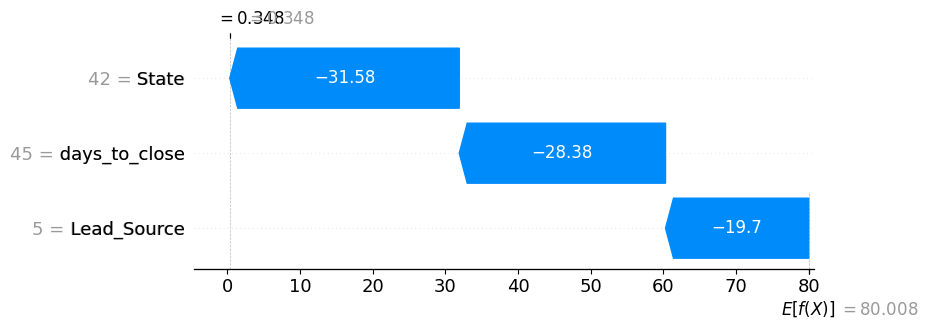

In [327]:
import shap 

explainer = shap.Explainer(xgb_model_train)
shap_values = explainer(X_train_new)
print(type(shap_values))
shap.plots.waterfall(shap_values[0])

In [328]:
print(shap_values)

.values =
array([[-19.698536  , -31.577612  , -28.383698  ],
       [  9.577297  ,  -1.1155835 ,  11.553483  ],
       [ -4.1559696 ,  -2.1119127 ,  26.283077  ],
       [ -1.1218107 ,  10.599244  ,  10.52167   ],
       [ -1.838665  ,  11.394218  ,  10.459637  ],
       [ 10.668986  ,  10.278963  ,  -0.8406841 ],
       [ -2.8322215 ,  -9.066475  ,  31.429855  ],
       [ -0.650611  ,   8.66822   ,  11.997584  ],
       [ -3.8003588 ,  27.567871  ,  -3.8319447 ],
       [ -3.7889137 ,  27.547394  ,  -4.0269647 ],
       [ 26.233097  ,  -2.0747838 ,  -4.1800766 ],
       [-49.07549   , -12.39123   , -18.187263  ],
       [ -2.7256308 ,  -3.3429978 ,  26.083824  ],
       [ 26.88982   ,  -2.5309207 ,  -4.3872957 ],
       [-17.50681   , -33.17349   , -29.074337  ],
       [  9.735984  ,  -1.0500097 ,  11.344122  ],
       [ 27.02617   ,  -2.6692743 ,  -4.3852873 ],
       [ -2.6038058 ,  -2.3579714 ,  24.993496  ],
       [-16.400063  , -12.640551  , -50.807835  ],
       [ -1.0990064 ,

In [329]:
import pandas as pd
importance_df = pd.DataFrame({
    "Feature": X_train_new.columns,
    "Mean SHAP Value": np.abs(shap_values.values).mean(axis=0)
}).sort_values(by="Mean SHAP Value", ascending=False)

print(importance_df)


         Feature  Mean SHAP Value
2  days_to_close        16.386229
0    Lead_Source        12.384571
1          State        11.036465


### Export Feature Importance

In [330]:
# Create the folder if it doesn't exist
os.makedirs("3_salesforce_feature_importance_data", exist_ok=True)

# Save the Excel file inside the folder
importance_df.to_csv("3_salesforce_feature_importance_data/3_salesforce_feature_importance_data.csv", index=False)


In [331]:
# spark_df = spark.createDataFrame(importance_df)
# spark_df.write.mode("overwrite").saveAsTable("sd_bdc_demo.xgboost_regression.3_salesforce_feature_importance_data")